In [1]:
import sys
sys.path.append("..")

In [2]:
import os
import shutil

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import batchflow
from batchflow import Pipeline, B, C, V, D
from batchflow.opensets import PascalSegmentation
from batchflow.research import Research, Option, Domain, Results, PrintLogger, RP, REP, KV
from batchflow.models.metrics import Loss
from batchflow.models.torch import UNet, EncoderDecoder

from matplotlib import pyplot as plt

In [3]:
BATCH_SIZE = 64
IMAGE_SHAPE = (160, 160)
dataset = PascalSegmentation(bar='n')

In [10]:
def process_mask(x):
    x = np.squeeze(x)
    np.place(x, x != 0, 1)
    return x

def rebatch_elements(images, masks):
    out_images = None
    out_masks = None
    for image, mask in zip(images, masks):
        if sum(mask[mask==1]) != mask.size:
            if not (out_images is None):
                out_images = np.vstack([out_images, image[np.newaxis]])                
                out_masks = np.vstack([out_masks, mask[np.newaxis]])
            else:
                out_images = image[np.newaxis]
                out_masks = mask[np.newaxis]
#     print("Images from batch:", out_images.shape[0])
    return out_images, out_masks


train_ppl = (dataset.train.p
    .init_variable('train_loss', [])
    .init_model('dynamic', C('model'), 'model', config=C('config'))
    .resize(size=IMAGE_SHAPE, src=['images', 'labels'], dst=['images', 'labels'])
    .to_array(channels='first', src=['images', 'labels'], dst=['images', 'labels'])
    .process_mask(B('labels'), save_to=B('labels'))
#     .rebatch_elements(B('images'), B('labels'), save_to=(B('images'), B('labels')))
#     .rebatch(BATCH_SIZE)
)

In [15]:
batch = train_ppl.next_batch(BATCH_SIZE)

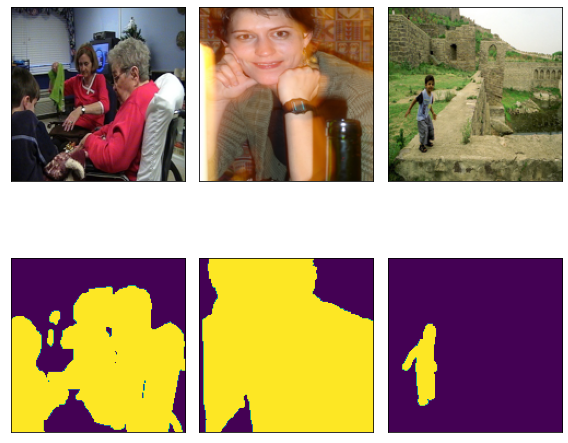

In [18]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(8, 8), subplot_kw={'xticks': [], 'yticks': []})

for picture_num, ax in enumerate(axs.flat):
    if picture_num < 3:        
        ax.imshow(np.moveaxis(batch.images[picture_num] / 255, 0, -1))
    elif picture_num < 6:
        ax.imshow(np.squeeze(batch.labels[picture_num-3]))


plt.tight_layout()
plt.show()